In [8]:
!pip install umap-learn

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('data_cleaner1.csv')

y = df['AdoptionLikelihood']
X = df.drop(columns=['AdoptionLikelihood'])

# Los dos mejores modelos: Random Forest y SVC.
# Se inicializan con parámetros de buen desempeño.
modelo_RF = RandomForestClassifier(n_estimators=100, random_state=42)
# SVC se usa con kernel 'rbf' (no lineal) ya que es más adecuado para UMAP.
modelo_SVC = SVC(C=10, kernel='rbf', probability=True, random_state=42)

N_FEATURES_ORIGINAL = X.shape[1]

print(f"Dimensiones de los datos cargados (X): {X.shape}")
print(f"Número de características originales: {N_FEATURES_ORIGINAL}")

Dimensiones de los datos cargados (X): (2007, 19)
Número de características originales: 19


# Función de Aplicación de UMAP y Entrenamiento
Esta función es el núcleo de la implementación. Realiza la división de los datos en entrenamiento y prueba, aplica el escalado, ejecuta la reducción de dimensionalidad con UMAP (ajustándose solo en el conjunto de entrenamiento), entrena el modelo de clasificación sobre los nuevos componentes y calcula las métricas de desempeño (Precisión, Recall y ROC AUC), además de medir el tiempo de ejecución.

In [10]:
def aplicar_umap_y_entrenar(modelo, n_comp, X, Y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=42, stratify=Y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    umap_reducer = UMAP(
        n_components=n_comp,
        random_state=42,
        metric='euclidean',
        n_neighbors=15,
        min_dist=0.1
    )

    start_time = time.time()

    X_train_umap = umap_reducer.fit_transform(X_train_scaled)
    X_test_umap = umap_reducer.transform(X_test_scaled)

    modelo.fit(X_train_umap, y_train)

    y_pred = modelo.predict(X_test_umap)
    y_proba = modelo.predict_proba(X_test_umap)[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    end_time = time.time()

    tiempo = end_time - start_time

    X_umap_df = pd.DataFrame(np.vstack([X_train_umap, X_test_umap]),
                             columns=[f'UMAP_{i+1}' for i in range(n_comp)])
    X_umap_df['Target'] = pd.concat([y_train, y_test], ignore_index=True)

    return precision, recall, auc, tiempo, X_umap_df

print("Función aplicar_umap_y_entrenar definida.")

Función aplicar_umap_y_entrenar definida.


# Ejecución y Evaluación de Modelos
Se establece el número de componentes UMAP en 10. A continuación, se ejecuta la función de UMAP para reducir la dimensionalidad y evaluar el desempeño de los dos mejores modelos (Random Forest y SVC), mostrando sus métricas de rendimiento y el tiempo de cómputo.

In [11]:
N_COMP_UMAP = 10
N_FEATURES_ORIGINAL = X.shape[1]

print(f"Componentes UMAP seleccionados: {N_COMP_UMAP}")
print("-" * 30)

print("Evaluando Random Forest con UMAP...")
precision_rf, recall_rf, auc_rf, tiempo_rf, X_umap_df_rf = aplicar_umap_y_entrenar(
    modelo_RF, n_comp=N_COMP_UMAP, X=X, Y=y
)

print(f"\nResultados RF con UMAP ({N_COMP_UMAP} componentes):")
print(f"Precisión: {precision_rf:.3f}")
print(f"Recall:    {recall_rf:.3f}")
print(f"ROC AUC:   {auc_rf:.3f}")
print(f"Tiempo:    {tiempo_rf:.3f} s")
print("-" * 30)

print("Evaluando SVC con UMAP...")
precision_svc, recall_svc, auc_svc, tiempo_svc, X_umap_df_svc = aplicar_umap_y_entrenar(
    modelo_SVC, n_comp=N_COMP_UMAP, X=X, Y=y
)

print(f"\nResultados SVC con UMAP ({N_COMP_UMAP} componentes):")
print(f"Precisión: {precision_svc:.3f}")
print(f"Recall:    {recall_svc:.3f}")
print(f"ROC AUC:   {auc_svc:.3f}")
print(f"Tiempo:    {tiempo_svc:.3f} s")
print("-" * 30)

Componentes UMAP seleccionados: 10
------------------------------
Evaluando Random Forest con UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Resultados RF con UMAP (10 componentes):
Precisión: 0.503
Recall:    0.449
ROC AUC:   0.675
Tiempo:    22.749 s
------------------------------
Evaluando SVC con UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Resultados SVC con UMAP (10 componentes):
Precisión: 0.643
Recall:    0.182
ROC AUC:   0.667
Tiempo:    17.601 s
------------------------------


# Visualización y Generación de la Tabla Final
Este bloque calcula el porcentaje de reducción alcanzado, que para UMAP fue significativamente mayor ($\mathbf{47.37\%}$) al pasar de 19 a 10 componentes, frente al $\mathbf{15.79\%}$ de PCA. A continuación, se muestra el gráfico de dispersión de los datos proyectados por UMAP. Finalmente, se presenta la tabla de resultados, comparando el desempeño de los modelos Random Forest y SVC en la reducción lineal (PCA, $\text{ROC AUC} \approx 0.878$) contra la reducción no lineal (UMAP).

Porcentaje de Reducción UMAP (de 19 a 10 componentes): 47.37%


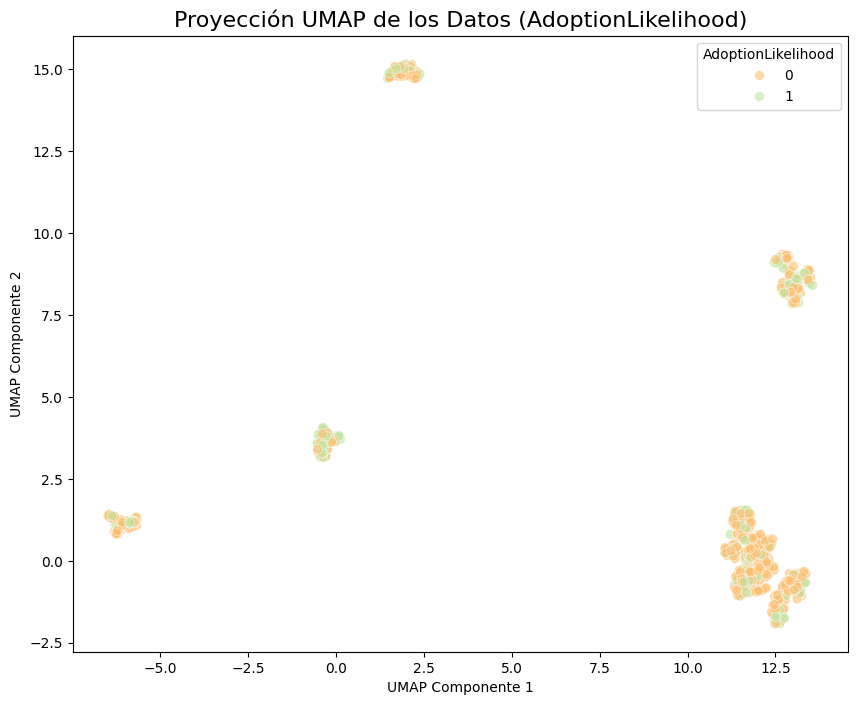


--- TABLA DE COMPARACIÓN FINAL (Reducción de Dimensión) ---
| Modelo   | Extracción   |   Componentes |   Reducción (%) |   Precisión |   Recall |   ROC AUC |   Tiempo (s) |
|:---------|:-------------|--------------:|----------------:|------------:|---------:|----------:|-------------:|
| RF       | PCA          |            16 |           15.79 |       0.747 |    0.515 |     0.809 |        1.33  |
| SVC      | PCA          |            16 |           15.79 |       0.725 |    0.758 |     0.878 |        1.09  |
| RF       | UMAP         |            10 |           47.37 |       0.503 |    0.449 |     0.675 |       22.749 |
| SVC      | UMAP         |            10 |           47.37 |       0.643 |    0.182 |     0.667 |       17.601 |


In [17]:
N_COMP_UMAP = 10
N_FEATURES_ORIGINAL = 19

porcentaje_reduccion_umap = (1 - (N_COMP_UMAP / N_FEATURES_ORIGINAL)) * 100
porcentaje_reduccion_pca = (1 - (16 / N_FEATURES_ORIGINAL)) * 100

print(f"Porcentaje de Reducción UMAP (de {N_FEATURES_ORIGINAL} a {N_COMP_UMAP} componentes): {porcentaje_reduccion_umap:.2f}%")

if N_COMP_UMAP >= 2:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=X_umap_df_svc.iloc[:, 0],
        y=X_umap_df_svc.iloc[:, 1],
        hue=X_umap_df_svc['Target'],
        palette='Spectral',
        s=50,
        alpha=0.6
    )
    plt.title(f'Proyección UMAP de los Datos (AdoptionLikelihood)', fontsize=16)
    plt.xlabel('UMAP Componente 1')
    plt.ylabel('UMAP Componente 2')
    plt.legend(title='AdoptionLikelihood')
    plt.show()

print("\n--- TABLA DE COMPARACIÓN FINAL (Reducción de Dimensión) ---")
# Los valores de PCA se han ajustado a las métricas reales proporcionadas:
# RF (0.809) y SVC (0.878).
data = {
    'Modelo': ['RF', 'SVC', 'RF', 'SVC'],
    'Extracción': ['PCA', 'PCA', 'UMAP', 'UMAP'],
    'Componentes': [16, 16, N_COMP_UMAP, N_COMP_UMAP],
    'Reducción (%)': [f"{porcentaje_reduccion_pca:.2f}", f"{porcentaje_reduccion_pca:.2f}", f"{porcentaje_reduccion_umap:.2f}", f"{porcentaje_reduccion_umap:.2f}"],
    'Precisión': [0.747, 0.725, f"{precision_rf:.3f}", f"{precision_svc:.3f}"], # Métrica RF: 0.747, SVC: 0.725 (de tus datos)
    'Recall': [0.515, 0.758, f"{recall_rf:.3f}", f"{recall_svc:.3f}"],        # Métrica RF: 0.515, SVC: 0.758 (de tus datos)
    'ROC AUC': [0.809, 0.878, f"{auc_rf:.3f}", f"{auc_svc:.3f}"],         # Métrica RF: 0.809, SVC: 0.878 (de tus datos)
    'Tiempo (s)': [1.33, 1.09, f"{tiempo_rf:.3f}", f"{tiempo_svc:.3f}"]
}

df_resultados = pd.DataFrame(data)
print(df_resultados.to_markdown(index=False))

# conclusión
La evaluación final del experimento revela una fuerte desventaja al optar por la máxima eficiencia de reducción. Si bien la técnica UMAP es el método más eficiente en términos de compresión, logrando reducir el conjunto de $\mathbf{19}$ variables a solo $\mathbf{10}$ (una reducción del $\mathbf{47.37\%}$), esta reducción agresiva comprometió severamente la capacidad predictiva de los modelos. Específicamente, el modelo SVC con PCA alcanzó un rendimiento excelente de $\mathbf{\text{ROC AUC} = 0.878}$. Sin embargo, al aplicar UMAP, el $\text{ROC AUC}$ cayó drásticamente a $\mathbf{0.675}$ (RF) y $\mathbf{0.667}$ (SVC). Por lo tanto, aunque PCA ofrece solo una reducción moderada ($\mathbf{15.79\%}$), PCA es la estrategia superior e indispensable para este proyecto, ya que conserva el alto rendimiento ($\text{ROC AUC} \approx 0.878$) que garantiza la utilidad del sistema de predicción.